## Setup

In [1]:
using RCall

R"""
library(rstan)
library(dplyr)
library(lubridate)
library(ggplot2)
library(bayesplot)

theme_set(bayesplot::theme_default())

# seed for R's pseudo-RNGs, not Stan's
set.seed(1123) 
"""

# Julia implementation:

┌ Warning: RCall.jl: Loading required package: StanHeaders
│ Loading required package: ggplot2
│ rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)
│ For execution on a local, multicore CPU with excess RAM we recommend calling
│ options(mc.cores = parallel::detectCores()).
│ To avoid recompilation of unchanged Stan programs, we recommend calling
│ rstan_options(auto_write = TRUE)
└ @ RCall /home/kusti/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘dplyr’
│ 
│ The following objects are masked from ‘package:stats’:
│ 
│     filter, lag
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     intersect, setdiff, setequal, union
│ 
└ @ RCall /home/kusti/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘lubridate’
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     date, intersect, setdiff, union
│ 
└ @ RCall /home/kusti/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: This is bayes

RObject{NilSxp}
NULL


## The problem

### Background

Imagine that you are a statistician or data scientist working as an independent contractor. One of your clients is a company that owns many residential buildings  throughout New York City. The property manager explains that they are concerned about the number of cockroach complaints that they receive from their buildings. Previously the company has offered monthly visits from a pest inspector as a solution to this problem. While this is the default solution of many property managers in NYC, the tenants are rarely home when the inspector visits, and so the manager reasons that this is a relatively expensive solution that is currently not very effective.

One alternative to this problem is to deploy long term bait stations. In this alternative, child and pet safe bait stations are installed throughout the apartment building. Cockroaches obtain quick acting poison from these stations and distribute it throughout the colony. The manufacturer of these bait stations provides some indication of the space-to-bait efficacy, but the manager suspects that this guidance was not calculated with NYC roaches in mind. NYC roaches, the manager rationalizes, have more hustle than traditional roaches; and NYC buildings are built differently than other common residential buildings in the US. This is particularly important as the unit cost for each bait station per year is quite high.

### The goal

The manager wishes to employ your services to help them to find the optimal number of roach bait stations they should place in each of their buildings in order to minimize the number of cockroach complaints while also keeping expenditure on pest control affordable. 

A subset of the company's buildings have been randomly selected for an experiment: 

  * At the beginning of each month, a pest inspector randomly places a number of

bait stations throughout the building, without knowledge of the current cockroach levels in the building

  * At the end of the month, the manager records

the total number of cockroach complaints in that building. 

  * The manager would like to determine the optimal number of traps ($\textrm{traps}$) that

balances the lost revenue ($R$) that complaints ($\textrm{complaints}$) generate with the all-in cost of maintaining the traps ($\textrm{TC}$). 

Fortunately, Bayesian data analysis provides a coherent framework for us to tackle this problem.

Formally, we are interested in finding

:$

\arg\max*{\textrm{traps} \in \mathbb{N}} \mathbb{E}*{\text{complaints}}[R(\textrm{complaints}(\textrm{traps})) - \textrm{TC}(\textrm{traps})] :$

The property manager would also, if possible, like to learn how these results  generalize to buildings they haven't treated so they can understand the potential costs of pest control at buildings they are acquiring as well as for the rest of their building portfolio.

As the property manager has complete control over the number of traps set, the random variable contributing to this expectation is the number of complaints given the number of traps. We will model the number of complaints as a function of the number of traps.

## The data

The data provided to us is in a file called `pest_data.RDS`. Let's load the data and see what the structure is:

In [2]:
R"""
pest_data <- readRDS('data/pest_data.RDS')
#str(pest_data)
"""

# Julia implementation:
using RData
using FileIO

pest_data = load(File(format"RDataSingle", "data/pest_data.RDS"));

We have access to the following fields: 

  * `complaints`: Number of complaints per building per month
  * `building_id`: The unique building identifier
  * `traps`: The number of traps used per month per building
  * `date`: The date at which the number of complaints are recorded
  * `live_in_super`: An indicator for whether the building as a live-in super
  * `age_of_building`: The age of the building
  * `total_sq_foot`: The total square footage of the building
  * `average_tenant_age`: The average age of the tenants per building
  * `monthly_average_rent`: The average monthly rent per building
  * `floors`: The number of floors per building

First, let's see how many buildings we have data for:

## Exercise: Unique buildings

Find out how many unique building there are in the data set.

In [3]:
R"""
N_buildings <- length(unique(pest_data$building_id))
N_buildings
"""

# Julia implementation:
N_buildings = length(unique(pest_data.building_id)); N_buildings

10

And make some plots of the raw data:

## Exercise: fixing the type of live_in_super

The column `live_in_super` has the wrong data type. The column indicates whether there is a live-in superintended in the building, so it is best encoded as a boolean, however the values are given as floats. Convert the column to the correct data type.

In [4]:
using DataFrames
transform!(pest_data, :live_in_super => (x -> convert.(Bool, x)) => :live_in_super);

## Exploratory data analysis

### Exercise: DataVoyager

Use DataVoyager to explore the dataset. What features do you believe would be useful in modeling the number of complaints?

In [5]:
using DataVoyager
p = pest_data |> Voyager();
#p[]

[293259:0705/185038.265763:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [6]:
@rlibrary ggplot2

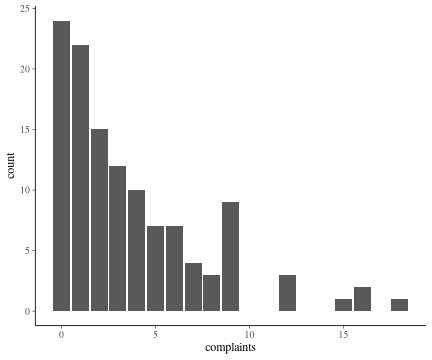

RObject{VecSxp}


In [7]:
R"""
ggplot(pest_data, aes(x = complaints)) + 
  geom_bar()
"""

ggplot(pest_data, aes(x=:complaints)) + geom_bar()

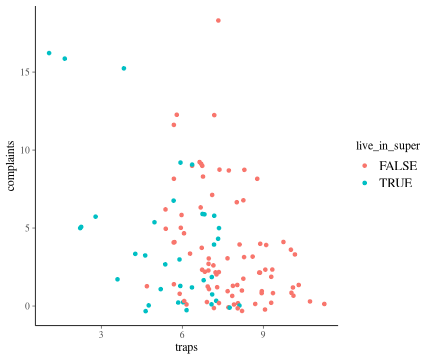

RObject{VecSxp}


In [8]:
R"""
ggplot(pest_data, aes(x = traps, y = complaints, color = live_in_super == TRUE)) + 
  geom_jitter()
"""

# Julia implementation:
ggplot(pest_data, aes(x = :traps, y = :complaints, color = :live_in_super)) + geom_jitter()

## Exercies: range method
Extend the `Base.range` method to dispatch on vectors. The output should be a vector with two elements: the miminum and the maximum of the elements in the argument vector. 

In [9]:
Base.range(x::Vector) = [minimum(x), maximum(x)]

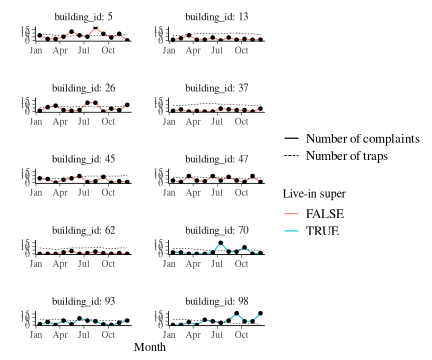

RObject{VecSxp}


In [10]:
R"""
ggplot(pest_data, aes(x = date, y = complaints, color = live_in_super == TRUE)) + 
  geom_line(aes(linetype = "Number of complaints")) + 
  geom_point(color = "black") + 
  geom_line(aes(y = traps, linetype = "Number of traps"), color = "black", size = 0.25) + 
  facet_wrap(~building_id, scales = "free", ncol = 2, labeller = label_both) + 
  scale_x_date(name = "Month", date_labels = "%b") + 
  scale_y_continuous(name = "", limits = range(pest_data$complaints)) + 
  scale_linetype_discrete(name = "") + 
  scale_color_discrete(name = "Live-in super")
"""

# Julia implementation:
ggplot(pest_data, aes(x = :date, y = :complaints, color = :live_in_super)) + 
  geom_line(aes(linetype = "Number of complaints")) + 
  geom_point(color = "black") + 
  geom_line(aes(y = :traps, linetype = "Number of traps"), color = "black", size = 0.25) + 
  facet_wrap(R"~building_id", scales = "free", ncol = 2, labeller = label_both) +
  scale_x_date(name = "Month", date_labels = "%b") +
  scale_y_continuous(name = "", limits = range(pest_data.complaints)) + 
  scale_linetype_discrete(name = "") + 
  scale_color_discrete(name = "Live-in super")

The first question we'll look at is just whether the number of complaints per building per month is associated with the number of bait stations per building per month, ignoring the temporal and across-building variation (we'll come back to those sources of variation later in the document). That requires only two variables, $\textrm{complaints}$ and $\textrm{traps}$. How should we model the number of complaints?

## Bayesian workflow

See slides

## Modeling count data : Poisson distribution

We already know some rudimentary information about what we should expect. The number of complaints over a month should be either zero or an integer. The property manager tells us that it is possible but unlikely that number of complaints in a given month is zero. Occasionally there are a very large number of complaints in a single month. A common way of modeling this sort of skewed, single bounded count data is as a Poisson random variable. One concern about modeling the outcome variable as Poisson is that the data may be over-dispersed, but we'll start with the Poisson model and then check  whether over-dispersion is a problem by comparing our model's predictions  to the data.

### Model

Given that we have chosen a Poisson regression, we define the likelihood to be the Poisson probability mass function over the number bait stations placed in the building, denoted below as `traps`. This model assumes that the mean and variance of the outcome variable `complaints` (number of complaints) is the same. We'll investigate whether this is a good assumption after we fit the  model.

For building $b = 1,\dots,10$ at time (month) $t = 1,\dots,12$, we have

:$

\begin{align*} \textrm{complaints}*{b,t} & \sim \textrm{Poisson}(\lambda*{b,t}) \
\lambda*{b,t} & = \exp{(\eta*{b,t})} \
\eta*{b,t} &= \alpha + \beta \, \textrm{traps}*{b,t} \end{align*} :$

Let's encode this probability model in a Stan program. 

### Writing our first Stan model

  * Write `simple_poisson_regression.stan` together

### Making sure our code is right

However, before we fit the model to real data, we should check that our model works well with simulated data. We'll simulate data according to the model and then check that we can sufficiently recover the parameter values used in the simulation.

  * Write `simple_poisson_regression_dgp.stan` together

We can use the `stan()` function to compile and fit the model, but here we will  do the compilation and fitting in two stages to demonstrate what is really  happening under the hood. 

First we will compile the Stan program (`simple_poisson_regression_dgp.stan`) that will generate the fake data.

In [11]:
using Distributions

function poisson_dgp(N, mean_traps)
    α = rand(Normal(log(4), .1))
    β = rand(Normal(-0.25, .1))
    traps = rand(Poisson(mean_traps), N)
    complaints = similar(traps)
    for i in eachindex(traps)
        complaints[i] = rand(Poisson(exp(α + β * traps[i])))
    end

    return (α = α, β = β, traps = traps, complaints = complaints)
end

poisson_dgp (generic function with 1 method)

In [12]:
fake_poisson = poisson_dgp(100, 5);

In [166]:
using Turing

Turing.@model simple_poisson_turing(μ_α, μ_β, traps, complaints) = begin
    α ~ Normal(μ_α , .1)
    β ~ Normal(μ_β, .1)

    for i in eachindex(traps)
        λ = exp(α + β * traps[i])
        complaints ~ Poisson(λ)
    end
end

DynamicPPL.ModelGen{var"###generator#291",(:μ_α, :μ_β, :traps, :complaints),,Tuple{}}(##generator#291, NamedTuple())

In [168]:
#R"""
#comp_dgp_simple <- stan_model('stan_programs/simple_poisson_regression_dgp.stan')
#"""

# Julia implementation:
using Soss

mu_alpha = log(4)
mu_beta = -0.25

simple_poisson = @model (μ_α, μ_β, traps) begin
    α ~ Normal(μ_α , 1)
    β ~ Normal(μ_β, 1)

    complaints ~ For(eachindex(traps)) do i
        λ = exp(α + β * traps[i])
        Poisson(λ)
    end
end

@model (μ_α, μ_β, traps) begin
        β ~ Normal(μ_β, 1)
        α ~ Normal(μ_α, 1)
        complaints ~ For(eachindex(traps)) do i
                λ = exp(α + β * traps[i])
                Poisson(λ)
            end
    end


In [169]:
using TransformVariables

In [170]:
args = (μ_α = log(4), μ_β=-0.25, traps=fake_poisson.traps)
data = (; complaints = fake_poisson.complaints)

(complaints = [1, 2, 1, 2, 1, 1, 4, 0, 3, 2  …  1, 3, 2, 0, 3, 1, 3, 0, 0, 0],)

In [171]:
t = xform(simple_poisson(; args...), data)

TransformVariables.TransformTuple{NamedTuple{(:β, :α),Tuple{TransformVariables.Identity,TransformVariables.Identity}}}((β = asℝ, α = asℝ), 2)

In [172]:
?advancedHMC

search: advancedHMC



```
advancedHMC(m, data, N = 1000; n_adapts = 1000)
```

Draw `N` samples from the posterior distribution of parameters defined in Soss model `m`, conditional on `data`. Samples are drawn using Hamiltonial Monte Carlo (HMC) from the `advancedHMC.jl` package.

## Keywords

  * `n_adapts = 1000`: The number of interations used to set HMC parameters.

Returns a tuple of length 2:

1. Samples from the posterior distribution of parameters.
2. Sample summary statistics.

## Example

```jldoctest

using Random
Random.seed!(42);

m = @model x begin
    β ~ Normal()
    yhat = β .* x
    y ~ For(eachindex(x)) do j
        Normal(yhat[j], 2.0)
    end
end

x = randn(3);
truth = rand(m(x=x));

post = advancedHMC(m(x=x), (y=truth.y,));
E_β = mean(post[1])[1]

println("true β: " * string(round(truth.β, digits=2)))
println("Posterior mean β: " * string(round(E_β, digits=2)))

# output
true β: -0.3
Posterior mean β: -0.25
```


In [173]:
apost = advancedHMC(simple_poisson(; args...), data)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/kusti/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


([[-1.0126383558416125, -1.3503540250166084], [-1.0126383558416125, -1.3503540250166084], [-0.3528949791218995, -1.2377833368429356], [-0.3528949791218995, -1.2377833368429356], [0.12328821564845134, -1.1346994643271782], [0.11589948195922468, -1.0817155584996738], [-0.23851254728611943, 1.266470944962914], [-0.22671536078331309, 1.2732186334625721], [-0.22671536078331309, 1.2732186334625721], [-0.203469089302394, 1.0270678286740806]  …  [-0.25735470886769035, 1.4912155411434225], [-0.3052288452465862, 1.3681019189523669], [-0.23846702795832553, 1.0566234593478123], [-0.33085251208740896, 1.5367439245448704], [-0.3375017493740316, 1.7401220753615345], [-0.28419405420010213, 1.569996216683314], [-0.32624733298414377, 1.585439757107554], [-0.24695435479662162, 1.0843692188747796], [-0.20008682177813364, 1.2208008141035538], [-0.20183425068245986, 1.099189885937456]], NamedTuple[(n_steps = 3, is_accept = true, acceptance_rate = 0.6666666666666666, log_density = -643.2116301452124, hamilto

In [175]:
apost_transformed = TransformVariables.transform.(t, apost[1])

1000-element Array{NamedTuple{(:β, :α),Tuple{Float64,Float64}},1}:
 (β = -1.0126383558416125, α = -1.3503540250166084)
 (β = -1.0126383558416125, α = -1.3503540250166084)
 (β = -0.3528949791218995, α = -1.2377833368429356)
 (β = -0.3528949791218995, α = -1.2377833368429356)
 (β = 0.12328821564845134, α = -1.1346994643271782)
 (β = 0.11589948195922468, α = -1.0817155584996738)
 (β = -0.23851254728611943, α = 1.266470944962914)
 (β = -0.22671536078331309, α = 1.2732186334625721)
 (β = -0.22671536078331309, α = 1.2732186334625721)
 (β = -0.203469089302394, α = 1.0270678286740806)
 (β = -0.24104036976289428, α = 1.2443392229507717)
 (β = -0.24087885966891243, α = 1.2244061151549896)
 (β = -0.2772852315235404, α = 1.4725263162816553)
 ⋮
 (β = -0.24264995375900755, α = 1.2331350889239516)
 (β = -0.2553543892074508, α = 1.3435657573818653)
 (β = -0.25735470886769035, α = 1.4912155411434225)
 (β = -0.3052288452465862, α = 1.3681019189523669)
 (β = -0.23846702795832553, α = 1.0566234593478123)


In [177]:
apostdf = apost_transformed |> DataFrame;

In [178]:
colwise(mean, apostdf)

┌ Warning: `colwise(f, d::AbstractDataFrame)` is deprecated, use `[f(col) for col = eachcol(d)]` instead.
│   caller = top-level scope at In[178]:1
└ @ Core In[178]:1


2-element Array{Float64,1}:
 -0.2439942639907491
  1.2208239091879352

In [176]:
dpost = dynamicHMC(simple_poisson(; args...), data)

1000-element Array{NamedTuple{(:β, :α),Tuple{Float64,Float64}},1}:
 (β = -0.2158462280041762, α = 1.2323490004016904)
 (β = -0.22185298842225062, α = 1.2732075283904276)
 (β = -0.2562591707167035, α = 1.2461834158419058)
 (β = -0.24948518278092896, α = 1.3194731545618514)
 (β = -0.2599499519699126, α = 1.3027588386456124)
 (β = -0.3002740862678907, α = 1.487709256863969)
 (β = -0.2725223479515937, α = 1.3266547812692393)
 (β = -0.27084689928099237, α = 1.3114820759683588)
 (β = -0.26707441566918777, α = 1.2850887382381357)
 (β = -0.21380436252504725, α = 1.1512466492057165)
 (β = -0.20257365765174712, α = 1.029176225289548)
 (β = -0.2466882586980922, α = 1.2738577072439807)
 (β = -0.3161788900340716, α = 1.5580361764739823)
 ⋮
 (β = -0.1596656697553016, α = 1.001987767438011)
 (β = -0.19944633981328136, α = 0.7866678805234953)
 (β = -0.16643882904779478, α = 0.8235998362485637)
 (β = -0.23661189358430193, α = 1.0074605680406006)
 (β = -0.29480288306458347, α = 1.3200032103261123)
 (β =

In [180]:
dpostdf = DataFrame(dpost)

,β,α
,Float64,Float64
1,-0.215846,1.23235
2,-0.221853,1.27321
3,-0.256259,1.24618
4,-0.249485,1.31947
5,-0.25995,1.30276
6,-0.300274,1.48771
7,-0.272522,1.32665
8,-0.270847,1.31148
9,-0.267074,1.28509


In [181]:
apostdf

,β,α
,Float64,Float64
1,-1.01264,-1.35035
2,-1.01264,-1.35035
3,-0.352895,-1.23778
4,-0.352895,-1.23778
5,0.123288,-1.1347
6,0.115899,-1.08172
7,-0.238513,1.26647
8,-0.226715,1.27322
9,-0.226715,1.27322


In [48]:
# Prior predictive
rand(simple_poisson(μ_α = log(4), μ_β = -0.25, traps = rand(0:10, 5)), 100) |> DataFrame;

In [15]:
#include("src/inference.jl")
#prior_predictive(simple_poisson(μ_α = log(4), μ_β = -0.25, traps = rand(0:10, 5)))

Printing this object shows the Stan program:

In [16]:
#R"""
#print(comp_dgp_simple)
#"""

# Julia implementation:

Now we can simulate the data by calling the `sampling()` function.

In [17]:
#R"""
#fitted_model_dgp <- sampling(
#  comp_dgp_simple,
#  data = list(N = nrow(pest_data), mean_traps = mean(pest_data$traps)),
#  chains = 1,
#  iter = 1,
#  algorithm = 'Fixed_param',
#  seed = 123
#  )
#
## see http://mc-stan.org/rstan/articles/stanfit_objects.html for various
## ways of extracting the contents of the stanfit object
#samps_dgp <- rstan::extract(fitted_model_dgp)
#str(samps_dgp)
#"""

# Julia implementation:

In [18]:
#reval("nuts_params(fitted_model_dgp)")

### Fit the model to the fake data:

In order to pass the fake data to our Stan program using RStan, we need to arrange the data into a named list. The names must match the names used  in the `data` block of the Stan program.

In [19]:
#R"""
#stan_dat_fake <- list(
#  N = nrow(pest_data), 
#  traps = samps_dgp$traps[1, ], 
#  complaints = samps_dgp$complaints[1, ]
#)
#str(stan_dat_fake)
#"""

# Julia implementation:

Now that we have the simulated data we fit the model to see if we can recover the `alpha` and `beta` parameters used in the simulation.

In [21]:
fake_posterior = dynamicHMC(simple_poisson(μ_α = log(4), μ_β = -0.25, traps = fake_poisson.traps),
    (complaints=fake_poisson.complaints,), 1000) |> DataFrame;

In [162]:
simple_poisson_turing(
        log(4),
        -.25,
        fake_poisson.traps,
        fake_poisson.complaints)

DynamicPPL.Model{var"###evaluator#274",(:μ_α, :μ_β, :traps, :complaints),Tuple{Float64,Float64,Array{Int64,1},Array{Int64,1}},,DynamicPPL.ModelGen{var"###generator#275",(:μ_α, :μ_β, :traps, :complaints),,Tuple{}}}(##evaluator#274, (μ_α = 1.3862943611198906, μ_β = -0.25, traps = [9, 2, 6, 6, 4, 6, 5, 8, 2, 6  …  4, 6, 4, 3, 5, 10, 3, 13, 6, 3], complaints = [1, 2, 1, 2, 1, 1, 4, 0, 3, 2  …  1, 3, 2, 0, 3, 1, 3, 0, 0, 0]), DynamicPPL.ModelGen{var"###generator#275",(:μ_α, :μ_β, :traps, :complaints),,Tuple{}}(##generator#275, NamedTuple()))

In [167]:
turing_posterior = Turing.sample(
    simple_poisson_turing(
        log(4),
        -.25,
        fake_poisson.traps,
        fake_poisson.complaints),
    NUTS(200, 0.65), 2500)

MethodError: MethodError: no method matching +(::Float64, ::Array{Float64,1})
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(::Float64, !Matched::Float64) at float.jl:401
  +(!Matched::PyCall.PyObject, ::Any) at /home/kusti/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:13
  ...

In [24]:
#using BayesPlot
#BayesPlot.mcmc_recover_hist(fake_posterior, fake_poisson)

UndefVarError: UndefVarError: mcmc_recover_hist not defined

In [ ]:
#R"""
#comp_model_P <- stan_model('stan_programs/simple_poisson_regression.stan')
#fit_model_P <- sampling(comp_model_P, data = stan_dat_fake, seed = 123)
#
#posterior_alpha_beta <- as.matrix(fit_model_P, pars = c('alpha','beta'))
#head(posterior_alpha_beta)
#"""

# Julia implementation:

### Assess parameter recovery

In [50]:
include("src/bayesplot.jl")

ppc_dens_overlay (generic function with 1 method)

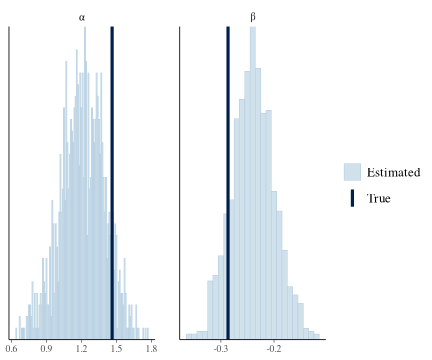

RObject{VecSxp}


In [49]:
mcmc_recover_hist(fake_posterior, fake_poisson, binwidth=0.01)

In [ ]:
#R"""
#true_alpha_beta <- c(samps_dgp$alpha, samps_dgp$beta)
#mcmc_recover_hist(posterior_alpha_beta, true = true_alpha_beta)
#"""

# Julia implementation:

We don't do a great job recovering the parameters here simply because we're simulating so few observations that the posterior uncertainty remains rather large, but it looks at least *plausible* ($\alpha$ and $\beta$ are contained within the histograms). If we did the simulation with many more observations the parameters would be estimated much more precisely.

We should also check if the `y_rep` datasets (in-sample predictions) that we coded  in the `generated quantities` block are similar to the `y` (complaints) values we conditioned on when fitting the model. (The **bayesplot** package [vignettes](http://mc-stan.org/bayesplot/articles/graphical-ppcs.html) are a good resource on this topic.)

Here is a plot of the density estimate of the observed data compared to  200 of the `y_rep` datasets:

In [137]:
include("src/inference.jl")

posterior_predictive (generic function with 2 methods)

In [107]:
args = (μ_α = log(4), μ_β = -0.25, traps = fake_poisson.traps)
data = (complaints=fake_poisson.complaints,)
joint = simple_poisson(; args...)
mdl = model(joint)
bound_arguments = arguments(joint)
post = dynamicHMC(joint, data, 1000);

In [148]:
post2 = advancedHMC(joint, data, 1000)

([[-0.744402290461645, 0.11083160541934339], [-0.744402290461645, 0.11083160541934339], [-0.3826854044952241, 0.21786036039839007], [-0.1615914073315633, 0.23795316361723678], [-0.09083781390302648, 0.22207713298869283], [-0.10646869241295777, 0.6449833229288788], [-0.22996074883392334, 1.2686805978956819], [-0.1941778595320772, 1.1425915102434214], [-0.20020351989567142, 1.1336994190243044], [-0.18109557071402443, 1.1444691071385715]  …  [-0.1991584882994812, 0.9507916083514021], [-0.19895260804535486, 0.9175496562684019], [-0.19585940004363125, 1.0390025488830403], [-0.2244962526699379, 0.9735612474966392], [-0.20722754542009028, 1.098689704661805], [-0.16029063867446341, 0.894902494794809], [-0.15216270102106516, 0.7940084104806712], [-0.1704412615662831, 0.718963250677597], [-0.1566018681604827, 0.7357116560265344], [-0.16492378152341297, 0.9218094668656771]], NamedTuple[(n_steps = 2, is_accept = true, acceptance_rate = 0.5, log_density = -373.30498526388396, hamiltonian_energy = 6

In [151]:
using DynamicHMC

In [154]:
using DynamicHMC.Diagnostics

In [108]:
latent_variables = setdiff(parameters(mdl), keys(data))

2-element Array{Symbol,1}:
 :α
 :β

In [135]:
pred = predictive(mdl, latent_variables...)
pred_args = arguments(pred)
const_args = NamedTupleTools.select(bound_arguments, intersect(pred_args, keys(bound_arguments)))
post_draw = post[1]
predargs = merge(const_args, post_draw)
pred_draw = rand(pred(predargs))
pd1 = delete(pred_draw, intersect(pred_args, keys(bound_arguments))...)
merge(pd1, post_draw)

(α = 1.3651423175427833, β = -0.2425272918446436, complaints = [2, 3, 0, 0, 1, 1, 1, 0, 1, 0  …  3, 0, 2, 1, 1, 0, 3, 0, 0, 4])

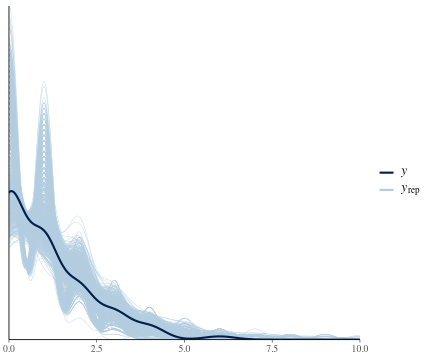

RObject{VecSxp}


In [147]:
popre = posterior_predictive(simple_poisson(; args...), data, post) |> DataFrame
complaints_rep = hcat(popre.complaints...)'

@rimport bayesplot
bayesplot.ppc_dens_overlay(fake_poisson.complaints, complaints_rep)

In [ ]:
#R"""
#y_rep <- as.matrix(fit_model_P, pars = "y_rep")
#ppc_dens_overlay(y = stan_dat_fake$complaints, yrep = y_rep[1:200, ])
#"""

# Julia implementation:

In [ ]:
R"""
ppc_dens_overlay(y=$y, yrep=$(y_rep[1:200, :]))
"""

In the plot above we have the kernel density estimate of the observed data ($y$, thicker curve) and 200 simulated data sets ($y_{rep}$, thin curves) from the posterior predictive distribution. If the model fits the data well, as it does here, there is little difference between the observed dataset and the simulated datasets.

Another plot we can make for count data is a rootogram. This is a plot of the expected counts (continuous line) vs the observed counts (blue histogram). We can see the model fits well because the observed histogram matches the expected counts relatively well.

In [ ]:
R"""
ppc_rootogram(stan_dat_fake$complaints, yrep = y_rep)
"""

# Julia implementation:

In [ ]:
R"""
ppc_rootogram($y, yrep=$(y_rep))
"""

### Fit with real data

To fit the model to the actual observed data we'll first create a list to pass to Stan using the variables in the `pest_data` data frame:

In [ ]:
R"""
stan_dat_simple <- list(
  N = nrow(pest_data), 
  complaints = pest_data$complaints,
  traps = pest_data$traps
)
"""

# Julia implementation:

As we have already compiled the model, we can jump straight to sampling from it.

In [ ]:
R"""
fit_P_real_data <- sampling(comp_model_P, data = stan_dat_simple)
"""

# Julia implementation:

and printing the parameters. What do these tell us?

In [ ]:
R"""
print(fit_P_real_data, pars = c('alpha','beta'))
"""

# Julia implementation:

We can also plot the posterior distributions:

In [ ]:
R"""
mcmc_hist(as.matrix(fit_P_real_data, pars = c('alpha','beta')))
"""

# Julia implementation:

As we expected, it appears the number of bait stations set in a building is associated with the number of complaints about cockroaches that were made in the following month. However, we still need to consider how well the model fits.

### Posterior predictive checking

In [ ]:
R"""
y_rep <- as.matrix(fit_P_real_data, pars = "y_rep")
"""

# Julia implementation:

In [ ]:
R"""
ppc_dens_overlay(y = stan_dat_simple$complaints, y_rep[1:200,])
"""

# Julia implementation:

As opposed to when we fit the model to simulated data above, here the simulated datasets is not as dispersed as the observed data and don't seem to capture the rate of zeros in the observed data. The Poisson model may not be sufficient for this data.

Let's explore this further by looking directly at the proportion of zeros in the real data and predicted data.

In [ ]:
R"""
prop_zero <- function(x) mean(x == 0)
ppc_stat(y = stan_dat_simple$complaints, yrep = y_rep, stat = "prop_zero")
"""

# Julia implementation:

In [ ]:
yrep = reval("y_rep")
y = reval("stan_dat_simple\$complaints")

In [ ]:
using Statistics
prop_zero_jl(x) = mean(x .== 0)

In [ ]:
prop_zero_jl([0, 1, 4, 0, 6, 7.])

In [ ]:
@rput prop_zero_jl

R"""
ppc_stat(y = $y, yrep = $yrep, stat = "prop_zero_jl")
"""

The plot above shows the observed proportion of zeros (thick vertical line) and a histogram of the proportion of zeros in each of the simulated data sets. It is clear that the model does not capture this feature of the data well at all.

This next plot is a plot of the standardised residuals of the observed vs predicted number of complaints.

In [ ]:
R"""
mean_y_rep <- colMeans(y_rep)
std_resid <- (stan_dat_simple$complaints - mean_y_rep) / sqrt(mean_y_rep)
qplot(mean_y_rep, std_resid) + hline_at(2) + hline_at(-2)
"""

# Julia implementation:

As you can see here, it looks as though we have more positive residuals than negative, which indicates that the model tends to underestimate the number of complaints that will be received.

The rootogram is another useful plot to compare the observed vs expected number of complaints. This is a plot of the expected counts (continuous line) vs the observed counts (blue histogram):

In [ ]:
R"""
ppc_rootogram(stan_dat_simple$complaints, yrep = y_rep)
"""

# Julia implementation:

If the model was fitting well these would be relatively similar, however in this figure we can see the number of complaints is underestimated if there are few complaints, over-estimated for medium numbers of complaints, and underestimated if there are a large number of complaints.

We can also view how the predicted number of complaints varies with the number of traps. From this we can see that the model doesn't seem to fully capture the data.

In [ ]:
R"""
ppc_intervals(
  y = stan_dat_simple$complaints, 
  yrep = y_rep,
  x = stan_dat_simple$traps
) + 
  labs(x = "Number of traps", y = "Number of complaints")
"""

# Julia implementation:

Specifically, the model doesn't capture the tails of the observed data very well.

## Expanding the model: multiple predictors

Modeling the relationship between complaints and bait stations is the simplest  model. We can expand the model, however, in a few ways that will be beneficial  for our client. Moreover, the manager has told us that they expect there are a number of other reasons that one building might have more roach complaints than another.

### Interpretability

Currently, our model's mean parameter is a rate of complaints per 30 days, but we're modeling a process that occurs over an area as well as over time. We have the square footage of each building, so if we add that information into the model, we can interpret our parameters as a rate of complaints per square foot per 30 days.

:$

\begin{align*} \textrm{complaints}*{b,t} & \sim \textrm{Poisson}(\textrm{sq*foot}*b\,\lambda*{b,t}) \
\lambda*{b,t} & = \exp{(\eta*{b,t} )} \
\eta*{b,t} &= \alpha + \beta \, \textrm{traps}*{b,t} \end{align*} :$

The term $\text{sq_foot}$ is called an exposure term. If we log the term, we can  put it in $\eta_{b,t}$:

:$

\begin{align*} \textrm{complaints}*{b,t} & \sim \textrm{Poisson}(\lambda*{b,t}) \
\lambda*{b,t} & = \exp{(\eta*{b,t} )} \
\eta*{b,t} &= \alpha + \beta \, \textrm{traps}*{b,t} + \textrm{log*sq*foot}_b \end{align*} :$

A quick test shows us that there appears to be a relationship between the square footage of the building and the number of complaints received:

In [ ]:
R"""
ggplot(pest_data, aes(x = log(total_sq_foot), y = log1p(complaints))) + 
  geom_point() + 
  geom_smooth(method = "lm", se = FALSE)
"""

# Julia implementation:

Using the property manager's intuition, we include two extra pieces of information we know about the building - the (log of the) square floor space and whether there is a live in super or not - into both the simulated and real data.

In [ ]:
R"""
stan_dat_simple$log_sq_foot <- log(pest_data$total_sq_foot/1e4)
stan_dat_simple$live_in_super <- pest_data$live_in_super
"""

# Julia implementation:

### Stan program for Poisson multiple regression

Now we need a new Stan model that uses multiple predictors.

  * Write `multiple_poisson_regression.stan` together

### Simulate fake data with multiple predictors

In [ ]:
R"""
comp_dgp_multiple <- stan_model('stan_programs/multiple_poisson_regression_dgp.stan')
"""

# Julia implementation:

In [ ]:
R"""
fitted_model_dgp <-
  sampling(
  comp_dgp_multiple,
  data = list(N = nrow(pest_data)),
  chains = 1,
  cores = 1,
  iter = 1,
  algorithm = 'Fixed_param',
  seed = 123
  )
samps_dgp <- rstan::extract(fitted_model_dgp)
"""

# Julia implementation:

Now pop that simulated data into a list ready for Stan.

In [ ]:
R"""
stan_dat_fake <- list(
  N = nrow(pest_data), 
  log_sq_foot = samps_dgp$log_sq_foot[1, ],
  live_in_super = samps_dgp$live_in_super[1, ],
  traps = samps_dgp$traps[1, ], 
  complaints = samps_dgp$complaints[1, ]
)
"""

# Julia implementation:

And then compile and fit the model we wrote for the multiple regression.

In [ ]:
R"""
comp_model_P_mult <- stan_model('stan_programs/multiple_poisson_regression.stan')
fit_model_P_mult <- sampling(comp_model_P_mult, data = stan_dat_fake, chains = 4, cores = 4)
"""

# Julia implementation:

Then compare these parameters to the true parameters:

In [ ]:
R"""
posterior_alpha_beta <- as.matrix(fit_model_P_mult, pars = c('alpha','beta','beta_super'))
true_alpha_beta <- c(samps_dgp$alpha,samps_dgp$beta,samps_dgp$beta_super)
mcmc_recover_hist(posterior_alpha_beta, true = true_alpha_beta)
"""

# Julia implementation:

We've recovered the parameters sufficiently well, so we've probably coded the Stan program correctly and we're ready to fit the real data.

### Fit the real data

Now let's use the real data and explore the fit.

In [ ]:
R"""
fit_model_P_mult_real <- sampling(comp_model_P_mult, data = stan_dat_simple)
y_rep <- as.matrix(fit_model_P_mult_real, pars = "y_rep")
ppc_dens_overlay(stan_dat_simple$complaints, y_rep[1:200,])
"""

# Julia implementation:

This again looks like we haven't captured the smaller counts very well, nor have we captured the larger counts.

In [ ]:
R"""
prop_zero <- function(x) mean(x == 0)
ppc_stat(y = stan_dat_simple$complaints, yrep = y_rep, stat = "prop_zero", binwidth = 0.01)
"""

# Julia implementation:

We're still severely underestimating the proportion of zeros in the data. Ideally this vertical line would fall somewhere within the histogram.

We can also plot uncertainty intervals for the predicted complaints for different numbers of traps.

In [ ]:
R"""
ppc_intervals(
  y = stan_dat_simple$complaints, 
  yrep = y_rep,
  x = stan_dat_simple$traps
) + 
  labs(x = "Number of traps", y = "Number of complaints")
"""

# Julia implementation:

We can see that we've increased the tails a bit more at the larger numbers of traps but we still have some large observed numbers of complaints that the model would consider extremely unlikely events. 

## Modeling count data with the Negative Binomial

When we considered modelling the data using a Poisson, we saw that the model didn't appear to fit as well to the data as we would like. In particular the model underpredicted low and high numbers of complaints, and overpredicted the medium number of complaints. This is one indication of over-dispersion, where the variance is larger than the mean. A Poisson model doesn't fit over-dispersed count data very well because the same parameter $\lambda$, controls both the expected counts and the variance of these counts. The natural alternative to this is the negative binomial model:

:$

\begin{align*} \text{complaints}*{b,t} & \sim \text{Neg-Binomial}(\lambda*{b,t}, \phi) \
\lambda*{b,t} & = \exp{(\eta*{b,t})} \
\eta*{b,t} &= \alpha + \beta \, {\rm traps}*{b,t} + \beta*{\rm super} \, {\rm super}*{b} + \text{log*sq*foot}_{b} \end{align*} :$

In Stan the negative binomial mass function we'll use is called  $\texttt{neg_binomial_2_log}(\text{ints} \, y, \text{reals} \, \eta, \text{reals} \, \phi)$  in Stan. Like the `poisson_log` function, this negative binomial mass function that is parameterized in terms of its log-mean, $\eta$, but it also has a precision $\phi$ such that

:$

\mathbb{E}[y] \, = \lambda = \exp(\eta) :$

:$

\text{Var}[y] = \lambda + \lambda^2/\phi = \exp(\eta) + \exp(\eta)^2 / \phi. :$ 

As $\phi$ gets larger the term $\lambda^2 / \phi$ approaches zero and so  the variance of the negative-binomial approaches $\lambda$, i.e., the negative-binomial gets closer and closer to the Poisson.

### Stan program for negative-binomial regression

  * Write `multiple_NB_regression.stan` together

### Fake data fit: Multiple NB regression

In [ ]:
R"""
comp_dgp_multiple_NB <- stan_model('stan_programs/multiple_NB_regression_dgp.stan')
"""

# Julia implementation:

We're going to generate one draw from the fake data model so we can use the data to fit our model and compare the known values of the parameters to the posterior density of the parameters.

In [ ]:
R"""
fitted_model_dgp_NB <-
  sampling(
  comp_dgp_multiple_NB,
  data = list(N = nrow(pest_data)),
  chains = 1,
  cores = 1,
  iter = 1,
  algorithm = 'Fixed_param',
  seed = 123
  )
samps_dgp_NB <- rstan::extract(fitted_model_dgp_NB)
"""

# Julia implementation:

Create a dataset to feed into the Stan model.

In [ ]:
R"""
stan_dat_fake_NB <- list(
  N = nrow(pest_data), 
  log_sq_foot = samps_dgp_NB$log_sq_foot[1, ],
  live_in_super = samps_dgp_NB$live_in_super[1, ],
  traps = samps_dgp_NB$traps[1, ], 
  complaints = samps_dgp_NB$complaints[1, ]
)
"""

# Julia implementation:

Compile the inferential model.

In [ ]:
R"""
comp_model_NB <- stan_model('stan_programs/multiple_NB_regression.stan')
"""

# Julia implementation:

Now we run our NB regression over the fake data and extract the samples to examine posterior predictive checks and to check whether we've sufficiently recovered our known parameters, $\text{alpha}$ $\texttt{beta}$, .

In [ ]:
R"""
fitted_model_NB <- sampling(comp_model_NB, data = stan_dat_fake_NB, 
                            chains = 4, cores = 4)
posterior_alpha_beta_NB <- 
  as.matrix(fitted_model_NB,
            pars = c('alpha',
                     'beta',
                     'beta_super',
                     'inv_phi')
  )
"""

# Julia implementation:

Construct the vector of true values from your simulated dataset and compare to the recovered parameters.

In [ ]:
R"""
true_alpha_beta_NB <- 
  c(samps_dgp_NB$alpha,
    samps_dgp_NB$beta,
    samps_dgp_NB$beta_super,
    samps_dgp_NB$inv_phi
  )
mcmc_recover_hist(posterior_alpha_beta_NB, true = true_alpha_beta_NB)
"""

# Julia implementation:

### Fit to real data and check the fit

In [ ]:
R"""
fitted_model_NB <- sampling(comp_model_NB, data = stan_dat_simple)
samps_NB <- rstan::extract(fitted_model_NB)
"""

# Julia implementation:

Let's look at our predictions vs. the data.

In [ ]:
R"""
y_rep <- samps_NB$y_rep
ppc_dens_overlay(stan_dat_simple$complaints, y_rep[1:200,])
"""

# Julia implementation:

It appears that our model now captures both the number of small counts better as well as the tails. 

Let's check if the negative binomial model does a better job capturing the number of zeros:

In [ ]:
R"""
ppc_stat(y = stan_dat_simple$complaints, yrep = y_rep, stat = "prop_zero")
"""

# Julia implementation:

These look OK, but let's look at the standardized residual plot.

In [ ]:
R"""
mean_inv_phi <- mean(samps_NB$inv_phi)
mean_y_rep <- colMeans(y_rep)
std_resid <- (stan_dat_simple$complaints - mean_y_rep) / sqrt(mean_y_rep + mean_y_rep^2*mean_inv_phi)
qplot(mean_y_rep, std_resid) + hline_at(2) + hline_at(-2)
"""

# Julia implementation:

Looks OK, but we still have some very large *standardized* residuals. This might be because we are currently ignoring that the data are clustered by buildings, and that the probability of roach issue may vary substantially across buildings.

In [ ]:
R"""
ppc_rootogram(stan_dat_simple$complaints, yrep = y_rep)
"""

# Julia implementation:

The rootogram now looks much more plausible. We can tell this because now the expected number of complaints matches much closer to the observed number of complaints. However, we still have some larger counts that appear to be outliers for the model.

Check predictions by number of traps:

In [ ]:
R"""
ppc_intervals(
  y = stan_dat_simple$complaints, 
  yrep = y_rep,
  x = stan_dat_simple$traps
) + 
  labs(x = "Number of traps", y = "Number of complaints")
"""

# Julia implementation:

We haven't used the fact that the data are clustered by building yet. A posterior  predictive check might elucidate whether it would be a good idea to add the building information into the model.

In [ ]:
R"""
ppc_stat_grouped(
  y = stan_dat_simple$complaints, 
  yrep = y_rep, 
  group = pest_data$building_id, 
  stat = 'mean',
  binwidth = 0.2
)
"""

# Julia implementation:

We're getting plausible predictions for most building means but some are estimated better than others and some have larger uncertainties than we might expect. If we explicitly model the variation across buildings we may be able to get much better estimates.

## Hierarchical modeling

### Modeling varying intercepts for each building

Let's add a hierarchical intercept parameter, $\alpha_b$ at the building level to our model.

:$

\text{complaints}*{b,t} \sim \text{Neg-Binomial}(\lambda*{b,t}, \phi) \
\lambda*{b,t}  = \exp{(\eta*{b,t})} \
\eta*{b,t} = \mu*b + \beta \, {\rm traps}*{b,t} + \beta*{\rm super}\, {\rm super}*b + \text{log*sq*foot}*b \
\mu*b \sim \text{Normal}(\alpha, \sigma*{\mu}) :$

In our Stan model, $\mu_b$ is the $b$-th element of the vector $\texttt{mu}$ which has one element per building.

One of our predictors varies only by building, so we can rewrite the above model more efficiently like so:

:$

\eta*{b,t} = \mu*b + \beta \, {\rm traps}*{b,t} + \text{log*sq*foot}*b\
\mu*b \sim \text{Normal}(\alpha +  \beta*{\text{super}} \, \text{super}*b , \sigma*{\mu}) :$

We have more information at the building level as well, like the average age of the residents, the average age of the buildings, and the average per-apartment monthly rent so we can add that data into a matrix called `building_data`, which will have one row per building and four columns:

  * `live_in_super`
  * `age_of_building`
  * `average_tentant_age`
  * `monthly_average_rent`

We'll write the Stan model like:

:$

\eta*{b,t} = \alpha*b + \beta \, {\rm traps} + \text{log*sq*foot}\
\mu \sim \text{Normal}(\alpha + \texttt{building*data} \, \zeta, \,\sigma*{\mu}) :$

### Prepare building data for hierarchical

We'll need to do some more data prep before we can fit our models. Firstly to use the building variable in Stan we will need to transform it from a factor variable to an integer variable.

In [ ]:
R"""
N_months <- length(unique(pest_data$date))

# Add some IDs for building and month
pest_data <- pest_data %>%
  mutate(
    building_fac = factor(building_id, levels = unique(building_id)),
    building_idx = as.integer(building_fac),
    ids = rep(1:N_months, N_buildings),
    mo_idx = lubridate::month(date)
  )

# Center and rescale the building specific data
building_data <- pest_data %>%
    select(
      building_idx,
      live_in_super,
      age_of_building,
      total_sq_foot,
      average_tenant_age,
      monthly_average_rent
    ) %>%
    unique() %>%
    arrange(building_idx) %>%
    select(-building_idx) %>%
    scale(scale=FALSE) %>%
    as.data.frame() %>%
    mutate( # scale by constants
      age_of_building = age_of_building / 10,
      total_sq_foot = total_sq_foot / 10000,
      average_tenant_age = average_tenant_age / 10,
      monthly_average_rent = monthly_average_rent / 1000
    ) %>%
    as.matrix()

# Make data list for Stan
stan_dat_hier <-
  with(pest_data,
        list(complaints = complaints,
             traps = traps,
             N = length(traps),
             J = N_buildings,
             M = N_months,
             log_sq_foot = log(pest_data$total_sq_foot/1e4),
             building_data = building_data[,-3],
             mo_idx = as.integer(as.factor(date)),
             K = 4,
             building_idx = building_idx
             )
        )
"""

# Julia implementation:

### Compile and fit the hierarchical model

Let's compile the model.

In [ ]:
R"""
comp_model_NB_hier <- stan_model('stan_programs/hier_NB_regression.stan')
"""

# Julia implementation:

Fit the model to data.

In [ ]:
R"""
fitted_model_NB_hier <-
  sampling(
  comp_model_NB_hier,
  data = stan_dat_hier,
  chains = 4,
  cores = 4,
  iter = 4000
  )
"""

# Julia implementation:

### Diagnostics

We get a bunch of warnings from Stan about divergent transitions, which is an indication that there may be regions of the posterior that have not been explored by the Markov chains.

Divergences are discussed in more detail in the course slides as well as the **bayesplot** (MCMC diagnostics vignette)[http://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html] and [*A Conceptual Introduction to Hamiltonian Monte Carlo*](https://arxiv.org/abs/1701.02434).

In this example we will see that we have divergent transitions because we need to reparameterize our model - i.e., we will retain the overall structure of the model, but transform some of the parameters so that it is easier for Stan to sample from the parameter space. Before we go through exactly how to do this reparameterization, we will first go through what indicates that this is something that reparameterization will resolve. We will go through:

1. Examining the fitted parameter values, including the effective sample size
2. Traceplots and scatterplots that reveal particular patterns in locations of the divergences.

First let's extract the fits from the model.

In [ ]:
R"""
samps_hier_NB <- rstan::extract(fitted_model_NB_hier)
"""

# Julia implementation:

Then we print the fits for the parameters that are of most interest.

In [ ]:
R"""
print(fitted_model_NB_hier, pars = c('sigma_mu','beta','alpha','phi','mu'))
"""

# Julia implementation:

You can see that the effective samples are quite low for many of the parameters relative to the total number of samples. This alone isn't indicative of the need to reparameterize, but it indicates that we should look further at the trace plots and pairs plots. First let's look at the traceplots to see if the divergent transitions form a pattern.

In [ ]:
R"""
# use as.array to keep the markov chains separate for trace plots
mcmc_trace(
  as.array(fitted_model_NB_hier,pars = 'sigma_mu'),
  np = nuts_params(fitted_model_NB_hier),
  window = c(500,1000)
)
"""

# Julia implementation:

Looks as if the divergent parameters, the little red bars underneath the traceplots correspond to samples where the sampler gets stuck at one parameter value for $\sigma_\mu$.

In [ ]:
R"""
# assign to object so we can compare to another plot later
scatter_with_divs <- mcmc_scatter(
  as.array(fitted_model_NB_hier),
  pars = c("mu[4]", 'sigma_mu'),
  transform = list('sigma_mu' = "log"),
  np = nuts_params(fitted_model_NB_hier)
)
scatter_with_divs
"""

# Julia implementation:

What we have here is a cloud-like shape, with most of the divergences clustering towards the bottom. We'll see a bit later that we actually want this to look more like a funnel than a cloud, but the divergences are indicating that the sampler can't explore the narrowing neck of the funnel.

One way to see why we should expect some version of a funnel is to look at some simulations from the prior, which we can do without MCMC and thus with no risk of sampling problems:

In [ ]:
R"""
N_sims <- 1000
log_sigma <- rep(NA, N_sims)
theta <- rep(NA, N_sims)
for (j in 1:N_sims) {
  log_sigma[j] <- rnorm(1, mean = 0, sd = 1)
  theta[j] <- rnorm(1, mean = 0, sd = exp(log_sigma[j]))
}
draws <- cbind("mu" = theta, "log(sigma_mu)" = log_sigma)
mcmc_scatter(draws)
"""

# Julia implementation:

Of course, if the data is at all informative we shouldn't expect the posterior to look exactly like the prior. But unless the data is incredibly informative about the parameters and the posterior concentrates away from the narrow neck of the funnel, the sampler is going to have to confront the funnel geometry. (See the [Visual MCMC Diagnostics](http://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html) vignette for more on this.)

Another way to look at the divergences is via a parallel coordinates plot:

In [ ]:
R"""
parcoord_with_divs <- mcmc_parcoord(
  as.array(fitted_model_NB_hier, pars = c("sigma_mu", "mu")),
  np = nuts_params(fitted_model_NB_hier)
)
parcoord_with_divs
"""

# Julia implementation:

Again, we see evidence that our problems concentrate when $\texttt{sigma_mu}$ is small.

### Reparameterize and recheck diagnostics

Instead, we should use the non-centered parameterization for $\mu_b$. We define a vector of auxiliary variables in the parameters block, $\texttt{mu_raw}$ that is given a $\text{Normal}(0, 1)$ prior in the model block. We then make $\texttt{mu}$ a transformed parameter: We can reparameterize the random intercept $\mu_b$, which is distributed:

:$

\mu*b \sim \text{Normal}(\alpha + \texttt{building*data} \, \zeta, \sigma_{\mu}) :$

```
transformed parameters {
  vector[J] mu;
  mu = alpha + building_data * zeta + sigma_mu * mu_raw;
}
```

This gives $\texttt{mu}$ a $\text{Normal}(\alpha + \texttt{building_data}\, \zeta, \sigma_\mu)$ distribution, but it decouples the dependence of the density of each element of $\texttt{mu}$ from $\texttt{sigma_mu}$ ($\sigma_\mu$). hier*NB*regression_ncp.stan uses the non-centered parameterization for $\texttt{mu}$. We will examine the effective sample size of the fitted model to see whether we've fixed the problem with our reparameterization.

Compile the model.

In [ ]:
R"""
comp_model_NB_hier_ncp <- stan_model('stan_programs/hier_NB_regression_ncp.stan')
"""

# Julia implementation:

Fit the model to the data.

In [ ]:
R"""
fitted_model_NB_hier_ncp <- sampling(comp_model_NB_hier_ncp, data = stan_dat_hier, chains = 4, cores = 4, control = list(adapt_delta = 0.95))
"""

# Julia implementation:

Examining the fit of the new model

In [ ]:
R"""
print(fitted_model_NB_hier_ncp, pars = c('sigma_mu','beta','alpha','phi','mu'))
"""

# Julia implementation:

This has improved the effective sample sizes of $\texttt{mu}$. We extract the parameters to run our usual posterior predictive checks.

In [ ]:
R"""
scatter_no_divs <- mcmc_scatter(
  as.array(fitted_model_NB_hier_ncp),
  pars = c("mu[4]", 'sigma_mu'),
  transform = list('sigma_mu' = "log"),
  np = nuts_params(fitted_model_NB_hier_ncp)
)
bayesplot_grid(scatter_with_divs, scatter_no_divs,
               grid_args = list(ncol = 2), ylim = c(-11, 1))
"""

# Julia implementation:

In [ ]:
R"""
parcoord_no_divs <- mcmc_parcoord(
  as.array(fitted_model_NB_hier_ncp, pars = c("sigma_mu", "mu")),
  np = nuts_params(fitted_model_NB_hier_ncp)
)
bayesplot_grid(parcoord_with_divs, parcoord_no_divs,
               ylim = c(-3, 3))
"""

# Julia implementation:

In [ ]:
R"""
samps_NB_hier_ncp <- rstan::extract(fitted_model_NB_hier_ncp, pars = c('y_rep','inv_phi'))
"""

# Julia implementation:

The marginal plot, again.

In [ ]:
R"""
y_rep <- as.matrix(fitted_model_NB_hier_ncp, pars = "y_rep")
ppc_dens_overlay(stan_dat_hier$complaints, y_rep[1:200,])
"""

# Julia implementation:

This looks quite nice. If we've captured the building-level means well, then the posterior distribution of means by building should match well with the observed means of the quantity of building complaints by month.

In [ ]:
R"""
ppc_stat_grouped(
  y = stan_dat_hier$complaints,
  yrep = y_rep,
  group = pest_data$building_id,
  stat = 'mean',
  binwidth = 0.5
)
"""

# Julia implementation:

We weren't doing terribly with the building-specific means before, but now they are all well-captured by our model. The model is also able to do a decent job estimating within-building variability:

In [ ]:
R"""
ppc_stat_grouped(
  y = stan_dat_hier$complaints,
  yrep = y_rep,
  group = pest_data$building_id,
  stat = 'sd',
  binwidth = 0.5
)
"""

# Julia implementation:

Predictions by number of traps:

In [ ]:
R"""
ppc_intervals(
  y = stan_dat_hier$complaints,
  yrep = y_rep,
  x = stan_dat_hier$traps
) +
  labs(x = "Number of traps", y = "Number of complaints")
"""

# Julia implementation:

Standardized residuals:

In [ ]:
R"""
mean_y_rep <- colMeans(y_rep)
mean_inv_phi <- mean(as.matrix(fitted_model_NB_hier_ncp, pars = "inv_phi"))
std_resid <- (stan_dat_hier$complaints - mean_y_rep) / sqrt(mean_y_rep + mean_y_rep^2*mean_inv_phi)
qplot(mean_y_rep, std_resid) + hline_at(2) + hline_at(-2)
"""

# Julia implementation:

Rootogram:

In [ ]:
R"""
ppc_rootogram(stan_dat_hier$complaints, yrep = y_rep)
"""

# Julia implementation:

### Varying intercepts *and* varying slopes

We've gotten some new data that extends the number of time points for which we have observations for each building. This will let us explore how to expand the model a bit more with varying *slopes* in addition to the varying intercepts and also, later, also model temporal variation.

In [ ]:
R"""
stan_dat_hier <- readRDS('data/pest_data_longer_stan_dat.RDS')
"""

# Julia implementation:

Perhaps if the levels of complaints differ by building, the coefficient for the effect of traps on building does too. We can add this to our model and observe the fit.

:$

\text{complaints}*{b,t} \sim \text{Neg-Binomial}(\lambda*{b,t}, \phi)  \
\lambda*{b,t} = \exp{(\eta*{b,t})}\
\eta*{b,t} = \mu*b + \kappa*b \, \texttt{traps}*{b,t} + \text{log*sq*foot}*b \
\mu*b \sim \text{Normal}(\alpha + \texttt{building*data} \, \zeta, \sigma*{\mu}) \
\kappa*b \sim \text{Normal}(\beta + \texttt{building*data} \, \gamma, \sigma_{\kappa}) :$

Let's compile the model.

In [ ]:
R"""
comp_model_NB_hier_slopes <- stan_model('stan_programs/hier_NB_regression_ncp_slopes_mod.stan')
"""

# Julia implementation:

Fit the model to data and extract the posterior draws needed for our posterior predictive checks.

In [ ]:
R"""
fitted_model_NB_hier_slopes <-
  sampling(
    comp_model_NB_hier_slopes,
    data = stan_dat_hier,
    chains = 4, cores = 4,
    control = list(adapt_delta = 0.95)
  )
"""

# Julia implementation:

To see if the model infers building-to-building differences in, we can plot a histogram of our marginal posterior distribution for `sigma_kappa`.

In [ ]:
R"""
mcmc_hist(
  as.matrix(fitted_model_NB_hier_slopes, pars = "sigma_kappa"),
  binwidth = 0.005
)
"""

# Julia implementation:

In [ ]:
R"""
print(fitted_model_NB_hier_slopes, pars = c('kappa','beta','alpha','phi','sigma_mu','sigma_kappa','mu'))
"""

# Julia implementation:

In [ ]:
R"""
mcmc_hist(
  as.matrix(fitted_model_NB_hier_slopes, pars = "beta"),
  binwidth = 0.005
)
"""

# Julia implementation:

While the model can't specifically rule out zero from the posterior, it does have mass at small non-zero numbers, so we should leave in the hierarchy over $\texttt{kappa}$. Plotting the marginal data density again, we can see the model still looks well calibrated.

In [ ]:
R"""
y_rep <- as.matrix(fitted_model_NB_hier_slopes, pars = "y_rep")
ppc_dens_overlay(
  y = stan_dat_hier$complaints,
  yrep = y_rep[1:200,]
)
"""

# Julia implementation:

## Time varying effects and structured priors

We haven't looked at how cockroach complaints change over time. Let's look at whether there's any pattern over time.

In [ ]:
R"""
select_vec <- which(stan_dat_hier$mo_idx %in% 1:12)
ppc_stat_grouped(
  y = stan_dat_hier$complaints[select_vec],
  yrep = y_rep[,select_vec],
  group = stan_dat_hier$mo_idx[select_vec],
  stat = 'mean'
) + xlim(0, 11)
"""

# Julia implementation:

We might augment our model with a log-additive monthly effect, $\texttt{mo}_t$.

:$

\eta*{b,t} = \mu*b + \kappa*b \, \texttt{traps}*{b,t} + \texttt{mo}*t + \text{log*sq*foot}*b :$

We have complete freedom over how to specify the prior for $\texttt{mo}_t$. There are several competing factors for how the number of complaints might change over time. It makes sense that there might be more roaches in the environment during the summer, but we might also expect that there is more roach control in the summer as well. Given that we're modeling complaints, maybe after the first sighting of roaches in a building, residents are more vigilant, and thus complaints of roaches would increase.

This can be a motivation for using an autoregressive prior for our monthly effects. The model is as follows:

:$

\texttt{mo}*t \sim \text{Normal}(\rho \, \texttt{mo}*{t-1}, \sigma*\texttt{mo}) \
\equiv \
\texttt{mo}*t = \rho \, \texttt{mo}*{t-1} +\epsilon*t , \quad \epsilon*t \sim \text{Normal}(0, \sigma*\texttt{mo}) \
\quad \rho \in [-1,1] :$

This equation says that the monthly effect in month $t$ is directly related to the last month's monthly effect. Given the description of the process above, it seems like there could be either positive or negative associations between the months, but there should be a bit more weight placed on positive $\rho$s, so we'll put an informative prior that pushes the parameter $\rho$ towards 0.5.

Before we write our prior, however, we have a problem: Stan doesn't implement any densities that have support on $[-1,1]$. We can use variable transformation of a raw variable defined on $[0,1]$ to to give us a density on $[-1,1]$. Specifically,

:$

\rho*{\text{raw}} \in [0, 1] \
\rho = 2 \times \rho*{\text{raw}} - 1 :$

Then we can put a beta prior on $\rho_\text{raw}$ to push our estimate towards 0.5.

One further wrinkle is that we have a prior for $\texttt{mo}_t$ that depends on $\texttt{mo}_{t-1}$. That is, we are working with the *conditional* distribution of $\texttt{mo}_t$ given $\texttt{mo}_{t-1}$. But what should we do about the prior for $\texttt{mo}_1$, for which we don't have a previous time period in the data?

We need to work out the *marginal* distribution of the first observation. Thankfully we can use the fact that AR models are stationary, so $\text{Var}(\texttt{mo}_t) = \text{Var}(\texttt{mo}_{t-1})$ and $\mathbb{E}(\texttt{mo}_t) = \mathbb{E}(\texttt{mo}_{t-1})$ for all $t$. Therefore the marginal distribution of $\texttt{mo}_1$ is the same as the marginal distribution of any $\texttt{mo}_t$.

First we derive the marginal variance of $\texttt{mo}_{t}$.

:$

\text{Var}(\texttt{mo}*t) = \text{Var}(\rho \texttt{mo}*{t-1} + \epsilon*t)  \
\text{Var}(\texttt{mo}*t) = \text{Var}(\rho \texttt{mo}*{t-1}) + \text{Var}(\epsilon*t) :$ where the second line holds by independence of $\epsilon_t$ and $\epsilon_{t-1})$. Then, using the fact that $Var(cX) = c^2Var(X)$ for a constant $c$ and the fact that, by stationarity, $\textrm{Var}(\texttt{mo}_{t-1}) = \textrm{Var}(\texttt{mo}_{t})$, we then obtain:

:$

\text{Var}(\texttt{mo}*t)= \rho^2 \text{Var}( \texttt{mo}*{t})  + \sigma*\texttt{mo}^2 \
\text{Var}(\texttt{mo}*t) = \frac{\sigma_\texttt{mo}^2}{1 - \rho^2} :$

For the mean of $\texttt{mo}_t$ things are a bit simpler:

:$

\mathbb{E}(\texttt{mo}*t) = \mathbb{E}(\rho \, \texttt{mo}*{t-1} + \epsilon*t) \
\mathbb{E}(\texttt{mo}*t) = \mathbb{E}(\rho \, \texttt{mo}*{t-1}) + \mathbb{E}(\epsilon*t) \
:$

Since $\mathbb{E}(\epsilon_t) = 0$ by assumption we have

:$

\mathbb{E}(\texttt{mo}*t) = \mathbb{E}(\rho \, \texttt{mo}*{t-1})  + 0\
\mathbb{E}(\texttt{mo}*t) = \rho \, \mathbb{E}(\texttt{mo}*{t}) \
\mathbb{E}(\texttt{mo}*t) - \rho \mathbb{E}(\texttt{mo}*t) = 0  \
\mathbb{E}(\texttt{mo}_t) = 0/(1 - \rho) :$

which for $\rho \neq 1$ yields $\mathbb{E}(\texttt{mo}_{t}) = 0$.

We now have the marginal distribution for $\texttt{mo}_{t}$, which, in our case, we will use for $\texttt{mo}_1$. The full AR(1) specification is then:

:$

\texttt{mo}*1 \sim \text{Normal}\left(0, \frac{\sigma*\texttt{mo}}{\sqrt{1 - \rho^2}}\right) \
\texttt{mo}*t \sim \text{Normal}\left(\rho \, \texttt{mo}*{t-1}, \sigma_\texttt{mo}\right) \forall t > 1 :$

In [ ]:
R"""
comp_model_NB_hier_mos <- stan_model('stan_programs/hier_NB_regression_ncp_slopes_mod_mos.stan')
"""

# Julia implementation:

In [ ]:
R"""
fitted_model_NB_hier_mos <- sampling(comp_model_NB_hier_mos, data = stan_dat_hier, chains = 4, cores = 4, control = list(adapt_delta = 0.9))
"""

# Julia implementation:

In the interest of brevity, we won't go on expanding the model, though we certainly could. What other information would help us understand the data generating process better? What other aspects of the data generating process might we want to capture that we're not capturing now?

As usual, we run through our posterior predictive checks.

In [ ]:
R"""
y_rep <- as.matrix(fitted_model_NB_hier_mos, pars = "y_rep")
ppc_dens_overlay(
  y = stan_dat_hier$complaints,
  yrep = y_rep[1:200,]
)
"""

# Julia implementation:

In [ ]:
R"""
select_vec <- which(stan_dat_hier$mo_idx %in% 1:12)
ppc_stat_grouped(
  y = stan_dat_hier$complaints[select_vec],
  yrep = y_rep[,select_vec],
  group = stan_dat_hier$mo_idx[select_vec],
  stat = 'mean'
)
"""

# Julia implementation:

As we can see, our monthly random intercept has captured a monthly pattern across all the buildings. We can also compare the prior and posterior for the autoregressive parameter to see how much we've learned. Here are two different ways of comparing the prior and posterior visually:

In [ ]:
R"""
# 1) compare draws from prior and draws from posterior
rho_draws <- cbind(
  2 * rbeta(4000, 10, 5) - 1, # draw from prior
  as.matrix(fitted_model_NB_hier_mos, pars = "rho")
)
colnames(rho_draws) <- c("prior", "posterior")
mcmc_hist(rho_draws, freq = FALSE, binwidth = 0.025,
          facet_args = list(nrow = 2)) + xlim(-1, 1)


# 2) overlay prior density curve on posterior draws
gen_rho_prior <- function(x) {
  alpha <- 10; beta <- 5
  a <- -1; c <- 1
  lp <- (alpha - 1) * log(x - a) +
        (beta - 1) * log(c - x) -
        (alpha + beta - 1) * log(c - a) -
         lbeta(alpha, beta)
  return(exp(lp))
}
mcmc_hist(as.matrix(fitted_model_NB_hier_mos, pars = "rho"),
          freq = FALSE, binwidth = 0.01) +
  overlay_function(fun = gen_rho_prior) +
  xlim(-1,1)
"""

# Julia implementation:

In [ ]:
R"""
print(fitted_model_NB_hier_mos, pars = c('rho','sigma_mu','sigma_kappa','gamma'))
"""

# Julia implementation:

In [ ]:
R"""
ppc_intervals(
  y = stan_dat_hier$complaints,
  yrep = y_rep,
  x = stan_dat_hier$traps
) +
  labs(x = "Number of traps", y = "Number of complaints")
"""

# Julia implementation:

It looks as if our model finally generates a reasonable posterior predictive distribution for all numbers of traps, and appropriately captures the tails of the data generating process.

## Using our model: Cost forecasts

Our model seems to be fitting well, so now we will go ahead and use the model to help us make a decision about how many traps to put in our buildings. We'll make a forecast for 6 months forward.

In [ ]:
R"""
comp_rev <- stan_model('stan_programs/hier_NB_regression_ncp_slopes_mod_mos_predict.stan')
print(comp_rev)
"""

# Julia implementation:

An important input to the revenue model is how much revenue is lost due to each complaint. The client has a policy that for every 10 complaints, they'll call an exterminator costing the client $100, so that'll amount to $10 per complaint.

In [ ]:
R"""
rev_model <- sampling(comp_rev, data = stan_dat_hier, cores = 4,
                      control = list(adapt_delta = 0.9))
"""

# Julia implementation:

Below we've generated our revenue curves for the buildings. These charts will give us precise quantification of our uncertainty around our revenue projections at any number of traps for each building.

A key input to our analysis will be the cost of installing bait stations. We're simulating the number of complaints we receive over the course of a year, so we need to understand the cost associated with maintaining each bait station over the course of a year. There's the cost attributed to the raw bait station, which is the plastic housing and the bait material, a peanut-buttery substance that's injected with insecticide. The cost of maintaining one bait station for a year plus monthly replenishment of the bait material is about $20.

In [ ]:
R"""
N_traps <- 20
costs <- 10 * (0:N_traps)
"""

# Julia implementation:

We'll also need labor for maintaining the bait stations, which need to be serviced every two months. If there are fewer than five traps, our in-house maintenance staff can manage the stations (about one hour of work every two months at $20/hour), but above five traps we need to hire outside pest control to help out. They're a bit more expensive, so we've put their cost at $30 / hour. Each five traps should require an extra person-hour of work, so that's factored in as well. The marginal person-person hours above five traps are at the higher pest-control-labor rate.

In [ ]:
R"""
N_months_forward <- 12
N_months_labor <- N_months_forward / 2
hourly_rate_low <- 20
hourly_rate_high <- 30
costs <- costs +
  (0:N_traps < 5 & 0:N_traps > 0) * (N_months_labor * hourly_rate_low) +
  (0:N_traps >= 5 & 0:N_traps < 10) * (N_months_labor * (hourly_rate_low + 1 * hourly_rate_high)) +
  (0:N_traps >= 10 & 0:N_traps < 15) * (N_months_labor * (hourly_rate_low + 2 * hourly_rate_high)) +
  (0:N_traps >= 15) * (N_months_labor * (hourly_rate_low + 3 * hourly_rate_high))
"""

# Julia implementation:

We can now plot curves with number of traps on the x-axis and profit/loss forecasts and uncertainty intervals on the y-axis.

In [ ]:
R"""
# extract as a list for convenience below
samps_rev <- rstan::extract(rev_model)

# total and mean profit
tot_profit <- sweep(samps_rev$rev_, 3, STATS = costs, FUN = '-')
mean_profit <- t(apply(tot_profit, c(2, 3), median))

# lower and upper ends of 50% central interval
lower_profit <- t(apply(tot_profit, c(2, 3), quantile, 0.25))
upper_profit <- t(apply(tot_profit, c(2, 3), quantile, 0.75))

profit_df <-
  data.frame(
    profit = as.vector(mean_profit),
    lower = as.vector(lower_profit),
    upper = as.vector(upper_profit),
    traps = rep(0:N_traps, times = N_buildings),
    building = rep(1:N_buildings, each = N_traps + 1)
  )
ggplot(data = profit_df, aes(x = traps, y = profit)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), fill = "grey70") +
  geom_line() +
  facet_wrap(~ building, scales = 'free_y', ncol = 2)
"""

# Julia implementation:

We can can see that the optimal number of bait stations differs by building.

<br>

Left as an exercise for the reader:

  * How would we build a revenue curve for a new building?
  * Let's say our utility function is revenue. If we wanted to maximize expected

revenue, we can take expectations at each station count for each building, and choose the trap numbers that maximizes expected revenue. This will be called a maximum revenue strategy. How can we generate the distribution of portfolio revenue (i.e. the sum of revenue across all the buildings) under the maximum revenue strategy from the the draws of `rev_pred` we already have?

## Gaussian process instead of AR(1)

### Joint density for AR(1) process

We can derive the joint distribution for the AR(1) process before we move to the Gaussian process (GP) which will give us a little more insight into what a GP is. Remember that we've specified the AR(1) prior as:

:$

\begin{aligned} \texttt{mo}*1 & \sim \text{Normal}\left(0, \frac{\sigma*\texttt{mo}}{\sqrt{1 - \rho^2}}\right) \
\texttt{mo}*t & \sim \text{Normal}\left(\rho \, \texttt{mo}*{t-1}, \sigma_\texttt{mo}\right) \forall t > 1 \end{aligned} :$ Rewriting our process in terms of the errors will make the derivation of the joint distribution clearer

:$

\begin{aligned} \texttt{mo}*1 & \sim \text{Normal}\left(0, \frac{\sigma*\texttt{mo}}{\sqrt{1 - \rho^2}}\right) \
\texttt{mo}*t & = \rho \, \texttt{mo}*{t-1} + \sigma*\texttt{mo}\epsilon*t  \
\epsilon_t & \sim \text{Normal}\left(0, 1\right) \end{aligned} :$

Given that our first term $\texttt{mo}_1$ is normally distributed, and subsequent terms are sums of normal random variables, we can see that jointly the vector, `mo`, with the $t$-th element equally the scalar $\texttt{mo}_t$, is multivariate normal, with mean zero (which we derived above). More formally, if we have a vector $x \in \mathbb{R}^M$ which is multivariate normal, $x \sim \text{MultiNormal}(0, \Sigma)$ and we left-multiply $x$ by a nonsingular matrix $L \in \mathbb{R}^{M\times M}$, $y = Lx \sim \text{MultiNormal}(0, L\Sigma L^T)$. We can use this fact to show that our vector `mo` is jointly multivariate normal.

Just as before with the noncentered parameterization, we'll be taking a vector $\texttt{mo_raw} \in \mathbb{R}^M$ in which each element is univariate $\text{Normal}(0,1)$ and transforming it into `mo`, but instead of doing the transformation with scalar transformations like in the section **Time varying effects and structured priors**, we'll do it with linear algebra operations. The trick is that by specifying each element of $\texttt{mo_raw}$ to be distributed $\text{Normal}(0,1)$ we are implicitly defining $\texttt{mo_raw} \sim \text{MultiNormal}(0, I_M)$, where $I_M$ is the identity matrix of dimension $M \times M$. Then we do a linear transformation using a matrix $L$ and assign the result to `mo` like $\texttt{mo} = L\times\texttt{mo_raw}$ so $\texttt{mo} \sim \text{MultiNormal}(0, LI_M L^T)$ and $LI_M L^T = LL^T$.

Consider the case where we have three elements in `mo` and we want to make figure out the form for $L$.

The first element of `mo` is fairly straightforward, because it mirrors our earlier parameterization of the AR(1) prior. The only difference is that we're explicitly adding the last two terms of `mo_raw` into the equation so we can use matrix algebra for our transformation. :$ \texttt{mo}*1 = \frac{\sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + 0 \times \texttt{mo*raw}*2 + 0 \times \texttt{mo*raw}*3\
:$ The second element is a bit more complicated:

:$

\begin{aligned} \texttt{mo}*2 & = \rho \texttt{mo}*1 + \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2 + 0 \times \texttt{mo*raw}*3  \
 & = \rho \left(\frac{\sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1\right) + \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2 + 0 \times \texttt{mo*raw}*3  \[5pt]  & = \frac{\rho \sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2 + 0 \times \texttt{mo*raw}_3  \
\end{aligned} :$

While the third element will involve all three terms :$ \begin{aligned} \texttt{mo}*3 & = \rho \, \texttt{mo}*2 + \sigma*{\texttt{mo}}\,\texttt{mo*raw}*3 \
 & = \rho \left(\frac{\rho \sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2\right) + \sigma*{\texttt{mo}} \texttt{mo*raw}*3  \[5pt] & = \frac{\rho^2 \sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + \rho \, \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2 +  \sigma*{\texttt{mo}}\,\texttt{mo*raw}_3  \
\end{aligned} :$

Writing this all together:

:$

\begin{aligned} \texttt{mo}*1 & = \frac{\sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + 0 \times \texttt{mo*raw}*2 + 0 \times \texttt{mo*raw}*3\[3pt] \texttt{mo}*2 & = \frac{\rho \sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2 + 0 \times \texttt{mo*raw}*3  \[3pt] \texttt{mo}*3 & = \frac{\rho^2 \sigma*{\texttt{mo}}}{\sqrt{1 - \rho^2}} \times \texttt{mo*raw}*1 + \rho \, \sigma*{\texttt{mo}}\,\texttt{mo*raw}*2 +  \sigma*{\texttt{mo}}\,\texttt{mo*raw}*3  \
\end{aligned} :$ Separating this into a matrix of coefficients $L$ and the vector `mo*raw`:

:$

\texttt{mo} = \begin{bmatrix} \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & 0 & 0 \
              \rho \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & \sigma*\texttt{mo} & 0 \
              \rho^2 \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & \rho \,\sigma*\texttt{mo}  & \sigma*\texttt{mo}               \end{bmatrix} \times \texttt{mo_raw} :$

If we multiply $L$ on the right by its transpose $L^T$, we'll get expressions for the covariance matrix of our multivariate random vector `mo`:

:$

\begin{bmatrix} \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & 0 & 0 \
\rho \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & \sigma*\texttt{mo} & 0 \
\rho^2 \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & \rho \,\sigma*\texttt{mo}  & \sigma*\texttt{mo} \end{bmatrix} \times \begin{bmatrix} \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & \rho \sigma*\texttt{mo} / \sqrt{1 - \rho^2} & \rho^2 \sigma*\texttt{mo} / \sqrt{1 - \rho^2} \
0 & \sigma*\texttt{mo} & \rho \,\sigma*\texttt{mo} \
0 & 0  & \sigma*\texttt{mo} \end{bmatrix} :$

which results in:

:$

\begin{bmatrix} \sigma^2*\texttt{mo} / (1 - \rho^2) & \rho \, \sigma^2*\texttt{mo} / (1 - \rho^2) &  \rho^2 \, \sigma^2*\texttt{mo} / (1 - \rho^2)\
\rho \, \sigma^2*\texttt{mo} / (1 - \rho^2)  & \sigma^2*\texttt{mo} / (1 - \rho^2)  & \rho \, \sigma^2*\texttt{mo} / (1 - \rho^2) \
\rho^2 \sigma^2*\texttt{mo} / (1 - \rho^2) & \rho \, \sigma^2*\texttt{mo} / (1 - \rho^2) & \sigma^2*\texttt{mo} / (1 - \rho^2) \end{bmatrix} :$ We can simplify this result by dividing the matrix by :\sigma^2*\texttt{mo} / (1 - \rho^2)$ to get

:$

\begin{bmatrix} 1 & \rho  &  \rho^2 \
\rho  & 1  & \rho  \
\rho^2 & \rho & 1 \end{bmatrix} :$

This should generalize to higher dimensions pretty easily. We could replace the Stan code in lines 59 to 63 in `stan_programs/hier_NB_regression_ncp_slopes_mod_mos.stan` with the following:

```
vector[M] mo;
{
  matrix[M,M] A = rep_matrix(0, M, M);
  A[1,1] = sigma_mo / sqrt(1 - rho^2);
  for (m in 2:M)
    A[m,1] = rho^(m-1) * sigma_mo / sqrt(1 - rho^2);
  for (m in 2:M) {
    A[m,m] = sigma_mo;
    for (i in (m + 1):M)
      A[i,m] = rho^(i-m) * sigma_mo;
  }
  mo = A * mo_raw;
}
```

It's important to the note that the existing Stan code in lines 59 to 63 is doing the exact same calculations but more efficiently.

### Cholesky decomposition

Note that if we only knew the covariance matrix of our process, say a matrix called $\Sigma$, and we had a way of decomposing $\Sigma$ into $L L^T$ we wouldn't need to write out the equation for the vector. Luckily, there is a matrix decomposition called the **Cholesky decomposition** that does just that. The Stan function for the composition is called `cholesky_decompose`. Instead of writing out the explicit equation, we could do the following:

```
vector[M] mo;
{
  mo = cholesky_decompose(Sigma) * mo_raw;
}
```

provided we've defined `Sigma` appropriately elsewhere in the transformed parameter block. Note that the matrix $L$ is lower-triangular (i.e. all elements in the upper right-hand triangle of the matrix are zero).

We've already derived the covariance matrix `Sigma` for the three-dimensional AR(1) process above by explicitly calculating $L L^T$, but we can do so using the rules of covariance and the way our process is defined. We already know that each element of $\texttt{mo}_t$ has marginal variance $\sigma^2_\texttt{mo} / (1 - \rho^2)$, but we don't know the covariance of $\texttt{mo}_t$ and $\texttt{mo}_{t+h}$. We can do so recursively. First we derive the covariance for two elements of $\texttt{mo}_t$ separated by one month:

:$

\text{Cov}(\texttt{mo}*{t+1},\texttt{mo}*{t}) = \text{Cov}(\rho \, \texttt{mo}*{t} + \sigma*\texttt{mo}\epsilon*{t+1},\texttt{mo}*{t}) \
\text{Cov}(\texttt{mo}*{t+1},\texttt{mo}*{t}) = \rho \text{Cov}(\texttt{mo}*{t},\texttt{mo}*{t}) + \sigma*\texttt{mo}\text{Cov}(\epsilon*{t+1},\texttt{mo}*{t}) \
\text{Cov}(\texttt{mo}*{t+1},\texttt{mo}*{t}) = \rho \text{Var}(\texttt{mo}*t) + 0 :$

Then we define the covariance for $\text{Cov}(\texttt{mo}_{t+h},\texttt{mo}_{t})$ in terms of $\text{Cov}(\texttt{mo}_{t+h-1},\texttt{mo}_{t})$

:$

\text{Cov}(\texttt{mo}*{t+h},\texttt{mo}*{t}) = \text{Cov}(\rho \, \texttt{mo}*{t+h-1} + \sigma*\texttt{mo}\epsilon*{t+h},\texttt{mo}*{t}) \
\text{Cov}(\texttt{mo}*{t+h},\texttt{mo}*{t}) = \rho \, \text{Cov}(\texttt{mo}*{t+h-1},\texttt{mo}*{t}) \
:$ Which we can use to recursively get at the covariance we need:

:$

\text{Cov}(\texttt{mo}*{t+h},\texttt{mo}*{t}) = \rho \, \text{Cov}(\texttt{mo}*{t+h-1},\texttt{mo}*{t}) \
\text{Cov}(\texttt{mo}*{t+h},\texttt{mo}*{t}) = \rho \,( \rho \, \text{Cov}(\texttt{mo}*{t+h-2},\texttt{mo}*{t}) )\
\dots \
\text{Cov}(\texttt{mo}*{t+h},\texttt{mo}*{t}) = \rho^h \, \text{Cov}(\texttt{mo}*{t},\texttt{mo}*{t}) \
\text{Cov}(\texttt{mo}*{t+h},\texttt{mo}*{t}) = \rho^h \, \sigma_\texttt{mo}^2/(1 - \rho^2) \
:$

Writing this in Stan code to replace lines 59 to 63 in `stan_programs/hier_NB_regression_ncp_slopes_mod_mos.stan` we would get:

```
vector[M] mo;
{
  matrix[M,M] Sigma;
  for (m in 1:M) {
    Sigma[m,m] = 1.0;
    for (i in (m + 1):M) {
      Sigma[i,m] = rho^(i - m);
      Sigma[m,i] = Sigma[i,m];
    }
  }
  Sigma = Sigma * sigma_mo^2 / (1 - rho^2);
  mo = cholesky_decompose(Sigma) * mo_raw;
}
```

### Extension to Gaussian processes

The prior we defined for `mo` is strictly speaking a Gaussian process. It is a stochastic process that is distributed as jointly multivariate normal for any finite value of $M$. Formally, we could write the above prior for `mo` like so:

:$

\begin{aligned}   \sigma*\texttt{mo} & \sim \text{Normal}(0, 1) \
  \rho & \sim \text{GenBeta}(-1,1,10, 5) \
  \texttt{mo}*t & \sim \text{GP}\left( 0,   K(t | \sigma*\texttt{mo},\rho) \right) \
\end{aligned} :$ The notation :K(t | \sigma*\texttt{mo},\rho)$ defines the covariance matrix of the process over the domain $t$, which is months.

In other words:

:$

\text{Cov}(\texttt{mo}*t,\texttt{mo}*{t+h}) = k(t, t+h | \sigma_\texttt{mo}, \rho) :$

We've already derived the covariance for our process.  What if we want to use a different definition of `Sigma`?

As the above example shows defining a proper covariance matrix will yield a proper multivariate normal prior on a parameter. We need a way of defining a proper covariance matrix. These are symmetric positive definite matrices. It turns out there is a class of functions that define proper covariance matrices, called **kernel functions**. These functions are applied elementwise to construct a covariance matrix, $K$:

:$

K_{[t,t+h]} = k(t, t+h | \theta) :$ where $\theta$ are the hyperparameters that define the behavior of covariance matrix.

One such function is called the **exponentiated quadratic function**, and it happens to be implemented in Stan as `cov_exp_quad`. The function is defined as:

:$

\begin{aligned}   k(t, t+h | \theta) & = \alpha^2  \exp \left( - \dfrac{1}{2\ell^2} ((t+h) - t)^2 \right) \
  & = \alpha^2  \exp \left( - \dfrac{h^2}{2\ell^2} \right) \end{aligned} :$

The exponentiated quadratic kernel has two components to theta, $\alpha$, the marginal standard deviation of the stochastic process $f$ and $\ell$, the process length-scale.

The length-scale defines how quickly the covariance decays between time points, with large values of $\ell$ yielding a covariance that decays slowly, and with small values of $\ell$ yielding a covariance that decays rapidly. It can be seen interpreted as a measure of how nonlinear the `mo` process is in time.

The marginal standard deviation defines how large the fluctuations are on the output side, which in our case is the number of roach complaints per month across all buildings. It can be seen as a scale parameter akin to the scale parameter for our building-level hierarchical intercept, though it now defines the scale of the monthly deviations.

This kernel's defining quality is its smoothness; the function is infinitely differentiable. That will present problems for our example, but if we add some noise the diagonal of our covariance matrix, the model will fit well.

:$

k(t, t+h | \theta) = \alpha^2  \exp \left( - \dfrac{h^2}{2\ell^2} \right) + \text{if } h = 0, \, \sigma^2_\texttt{noise} \text{ else } 0 :$

### Compiling the GP model

In [ ]:
R"""
comp_model_NB_hier_gp <- stan_model('stan_programs/hier_NB_regression_ncp_slopes_mod_mos_gp.stan')
"""

# Julia implementation:

### Fitting the GP model to data

In [ ]:
R"""
fitted_model_NB_hier_gp <- sampling(comp_model_NB_hier_gp, data = stan_dat_hier, chains = 4, cores = 4, control = list(adapt_delta = 0.9))
samps_gp <- rstan::extract(fitted_model_NB_hier_gp)
"""

# Julia implementation:

### Examining the fit

Let's look at the prior vs. posterior for the GP length scale parameter:

In [ ]:
R"""
length_scale_draws <- cbind(
  prior = rgamma(4000, 10, 2),
  posterior = samps_gp$gp_len
)
mcmc_areas(length_scale_draws)
"""

# Julia implementation:

From the plot above it only looks like we learned a small amount, however we can see a bigger difference between the prior and posterior if we consider how much we learned about the ratio of `sigma_gp` to the length scale `gp_len`:

In [ ]:
R"""
noise_to_length_scale_ratio_draws <- cbind(
  prior = abs(rnorm(4000)) / rgamma(4000, 10, 2),
  posterior = samps_gp$sigma_gp / samps_gp$gp_len
)
mcmc_areas(noise_to_length_scale_ratio_draws)
"""

# Julia implementation:

This is a classic problem with Gaussian processes. Marginally, the length-scale parameter isn't very well-identified by the data, but jointly the length-scale and the marginal standard deviation are well-identified.

And let's compare the estimates for the time varying parameters between the AR(1) and GP. In this case the posterior mean of the time trend is essentially the same for the AR(1) and GP priors but the 50% uncertainty intervals are narrower for the AR(1):

In [ ]:
R"""
# visualizing 50% intervals
mo_ar_intervals <- mcmc_intervals_data(as.matrix(fitted_model_NB_hier_mos, pars = "mo"), prob = 0.5)
mo_gp_intervals <- mcmc_intervals_data(as.matrix(fitted_model_NB_hier_gp, pars = "gp"), prob = 0.5)
plot_data <- bind_rows(mo_ar_intervals, mo_gp_intervals)
plot_data$prior <- factor(rep(c("AR1", "GP"), each = 36), levels = c("GP", "AR1"))
plot_data$time <- rep(1:36, times = 2)

ggplot(plot_data, aes(x = time, y = m, ymin = l, ymax = h, fill = prior)) +
  geom_ribbon(alpha = 2/3)
"""

# Julia implementation:

The way we coded the GP also lets us plot a decomposition of the GP into a monthly noise component (`mo_noise` in the Stan code) and the underlying smoothly varying trend (`gp_exp_quad` in the Stan code):

In [ ]:
R"""
# visualizing 50% intervals
mo_noise_intervals <- mcmc_intervals_data(as.matrix(fitted_model_NB_hier_gp, pars = "mo_noise"), prob = 0.5)
gp_exp_quad_intervals <- mcmc_intervals_data(as.matrix(fitted_model_NB_hier_gp, pars = "gp_exp_quad"), prob = 0.5)

plot_data <- bind_rows(mo_noise_intervals, gp_exp_quad_intervals)
plot_data$time <- rep(1:36, times = 2)
plot_data$term <- factor(rep(c("Monthly Noise", "Smooth Trend"), each = 36),
                         levels = c("Smooth Trend", "Monthly Noise"))

ggplot(plot_data, aes(x = time, y = m, ymin = l, ymax = h, fill = term)) +
  geom_ribbon(alpha = 0.5) +
  geom_line(aes(color = term), size = 0.5) +
  ylab(NULL)
"""

# Julia implementation: